In [63]:
import numpy as np
import sklearn
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Dataset

In [64]:
nose_data = pd.read_csv('kanga.csv')
nose_data.iloc[:5]

,X,Y
0,609,241
1,629,222
2,620,233
3,564,207
4,645,247


# Exploratory Data Analysis Tasks

In [65]:
X, y = nose_data['X'], nose_data['Y']

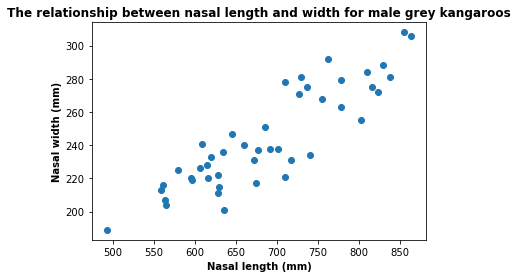

In [66]:
fig_01, ax = plt.subplots(1, 1)
ax.scatter(X, y)
ax.set_title('The relationship between nasal length and width for male grey kangaroos', fontweight = 'bold')
ax.set_xlabel('Nasal length (mm)', fontweight = 'bold')
ax.set_ylabel('Nasal width (mm)', fontweight = 'bold')
plt.show()

# Regression Tasks (From here I will use knn (k = 3) imputation strategy)

## 2.3.1

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
#X_train, X_test, y_train, y_test = imputations(nose_data, knn_imputation_pipeline) # Knn (k = 3) imputation
print(X_train.shape, X_test.shape)
print(any(X_train == np.nan), any(y_train == np.nan))

(40,) (5,)
False False


In [68]:
def adding_dim(*args):
    result = []
    for arg in args:
        arg = np.array(arg)[:, np.newaxis]
        result.append(arg)
    return result

In [69]:
X_train, X_test, y_train, y_test = adding_dim(X_train, X_test, y_train, y_test)

## 2.3.2

In [70]:
from sklearn.linear_model import LinearRegression

# Linear regression
linear_reg  = LinearRegression().fit(X_train, y_train)
linear_R2 = linear_reg.score(X_test, y_test)
print(f'R^2 score for linear regression {linear_R2:.4f}')
""" The model can explain 70.05% of variance in the data. I think it's a good fit"""

R^2 score for linear regression 0.7051


" The model can explain 70.05% of variance in the data. I think it's a good fit"

## 2.3.3

In [71]:
from sklearn.model_selection import cross_val_score

#Cross validation with full dataset
linear_reg_scores = cross_val_score(linear_reg, np.concatenate((X_train, X_test), axis = 0), np.concatenate((y_train, y_test), axis = 0))
print(f'Mean R^2 score: {np.mean(linear_reg_scores)}')

Mean R^2 score: 0.7123031029823781


## 2.3.4

In [72]:
X_new = np.concatenate((X_train, X_test), axis = 0)
y_new = np.concatenate((y_train, y_test), axis = 0)

In [73]:
y_new.shape

(45, 1)

In [74]:
a = np.array([1, 2, 3])
b = a.reshape(-1, 1)
b

array([[1],
       [2],
       [3]])

/home/kooi/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kooi/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kooi/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kooi/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

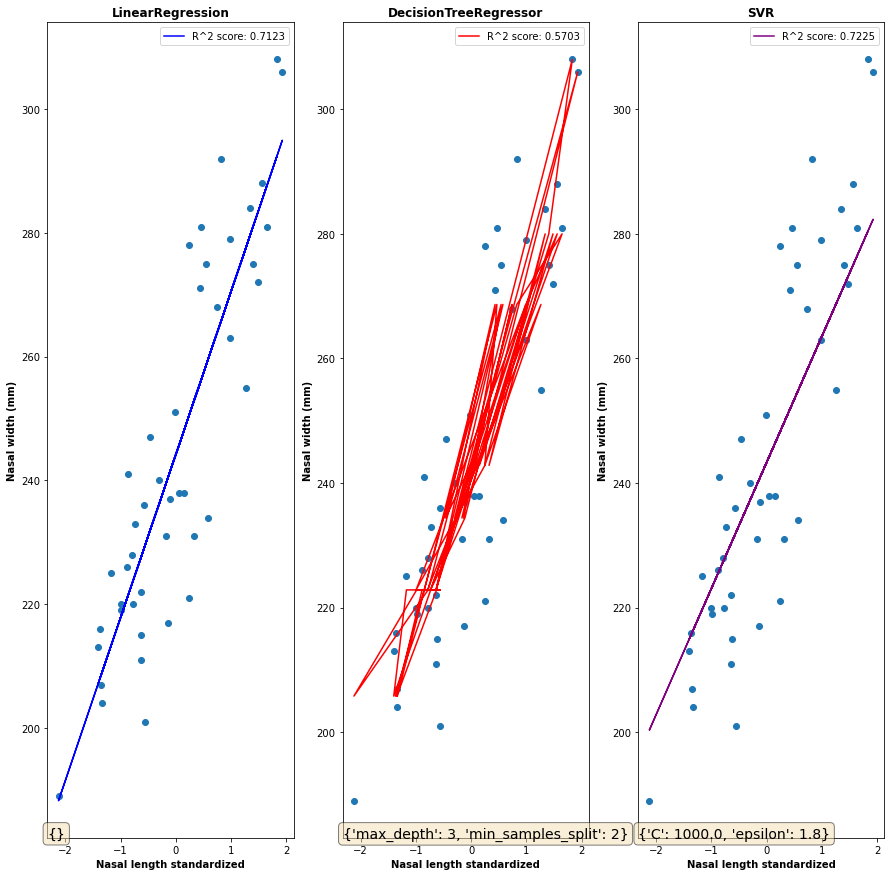

In [75]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

tree_reg = DecisionTreeRegressor(random_state = 42)
linear_SVM = SVR(kernel = 'linear', max_iter = 1000)

param_grid_tree_reg = [{'max_depth': [None, *list(range(1, 11))], 'min_samples_split': [*list(range(2, 11))]}]
param_grid_linear_SVM = [{'epsilon': list(np.arange(0.0, 2.0, 0.2)), 'C': [0.001 * (10 ** i) for i in range(7)]}]
c = ['blue', 'red', 'purple']
#grid_search
fig_02, ax = plt.subplots(1, 3, figsize = (15, 15))
def grid_search(model, param_grid, X, y, ax, color):
    search_pipeline = Pipeline([('std scaler', StandardScaler()), 
                         ('Grid search', GridSearchCV(model, param_grid, cv = 5, scoring = 'r2', refit = True))])
    search_pipeline.fit(X, y)
    best_model = search_pipeline['Grid search'].best_estimator_
    best_score = search_pipeline['Grid search'].best_score_
    best_params = search_pipeline['Grid search'].best_params_
    
    #Ploting the best model and R^2 score
    X = search_pipeline['std scaler'].transform(X)
    #y = search_pipeline['std scaler'].transform(y)
    y_pred = best_model.predict(X)
    ax.scatter(X, y)
    ax.set_title(f'{best_model.__class__.__name__}', fontweight = 'bold')
    ax.set_xlabel('Nasal length standardized', fontweight = 'bold')
    ax.set_ylabel('Nasal width (mm)', fontweight = 'bold')
    ax.plot(X, y_pred, label = f'R^2 score: {np.round(best_score, 4)}', color = color)
    ax.legend()
    #ax.text(0.5, 0.5, f'R^2 score: {best_score}')
    text = f'{best_params}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.annotate(text, (0, 0), xycoords = 'axes fraction', fontsize=14, bbox=props)
grid_search(linear_reg, [{}], X_new, y_new.ravel(), ax[0], c[0])
grid_search(tree_reg, param_grid_tree_reg, X_new, y_new.ravel(), ax[1], c[1])
grid_search(linear_SVM, param_grid_linear_SVM, X_new, y_new.ravel(), ax[2], c[2])
plt.show()    

In [76]:
fig_01.savefig('./kangaroos_images/figure_01.png', dpi = 300)

In [77]:
fig_02.savefig('./kangaroos_images/figure_02.png', dpi = 300)

# Missing Data Imputation Task

In [78]:
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

nose_missing_data = pd.read_csv('2039045/2039045_nose.csv', index_col = 0)

# Two strategies for imputating the data
mean_imputation_pipeline = ColumnTransformer([
     ('mean imputation', SimpleImputer(strategy = 'mean'), ['X', 'Y']),
])
knn_imputation_pipeline = ColumnTransformer([
    ('knn imputation', KNNImputer(n_neighbors = 3), ['X', 'Y']),
])

def adding_dim(*args):
    result = []
    for arg in args:
        arg = np.array(arg)[:, np.newaxis]
        result.append(arg)
    return result

def imputations(data, impute_strat):
    data_imputated = impute_strat.fit_transform(data)
    X_train, X_test, y_train, y_test = train_test_split(data_imputated[:, 0], data_imputated[:, 1], test_size = 0.1, random_state = 42)
    X_train, X_test, y_train, y_test = adding_dim(X_train, X_test, y_train, y_test)
    return X_train, X_test, y_train, y_test
# Mean imputation  
X_train_mean, X_test_mean, y_train_mean, y_test_mean = imputations(nose_missing_data, mean_imputation_pipeline)
print('R^2 score for mean imputation: ', LinearRegression().fit(X_train_mean, y_train_mean).score(X_test_mean, y_test_mean))

# Knn (k = 3) imputation
X_train_knn, X_test_knn, y_train_knn, y_test_knn = imputations(nose_missing_data, knn_imputation_pipeline)
print('R^2 score for knn(k = 3) imputation: ', LinearRegression().fit(X_train_knn, y_train_knn).score(X_test_knn, y_test_knn))
"""We can see that the model with knn (k = 3) imputation has a higher R^2 score"""

R^2 score for mean imputation:  0.5374951243625063
R^2 score for knn(k = 3) imputation:  0.6289261544969535


'We can see that the model with knn (k = 3) imputation has a higher R^2 score'